In [23]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [24]:
log_directory_tls12 = "/home/admin/C2_TLS/datasets/ms/TLS1.2/short_cert/zeek_logs"
log_files12 = [f for f in os.listdir(log_directory_tls12) if f.endswith('.log')]

log_directory_tls13 = "/home/admin/C2_TLS/datasets/ms/TLS1.3/zeek_logs"
log_files13 = [f for f in os.listdir(log_directory_tls13) if f.endswith('.log')]

df_list = []

for log_file in log_files12:
    file_path = os.path.join(log_directory_tls12, log_file)
    df = pd.read_csv(file_path, sep=",", header=None, skiprows=8, low_memory=False)
    df = df.iloc[:-1]
    df.replace("-", pd.NA, inplace=True)
    df = df.dropna()
    df_list.append(df)

for log_file in log_files13:
    file_path = os.path.join(log_directory_tls13, log_file)
    df = pd.read_csv(file_path, sep=",", header=None, skiprows=8, low_memory=False)
    df = df.iloc[:-1]
    df.replace("-", pd.NA, inplace=True)
    df = df.dropna()
    df_list.append(df)



headers = ['client_hello_len','client_hello_ext_num','server_hello_len','server_hello_ext_num']
df_ms = pd.concat(df_list, ignore_index=True)
df_ms.shape
df_ms = shuffle(df_ms, random_state=42)
df_ms.reset_index(drop=True, inplace=True)
df_ms = df_ms.set_axis(headers, axis=1)
df_ms['c2'] = 1
df_ms['source'] = 'MS'

In [25]:
log_directory_tls12 = "/home/admin/C2_TLS/datasets/tranco/TLS1.2/zeek_logs"
log_files12 = [f for f in os.listdir(log_directory_tls12) if f.endswith('.log')]

log_directory_tls13 = "/home/admin/C2_TLS/datasets/tranco/TLS1.3/zeek_logs"
log_files13 = [f for f in os.listdir(log_directory_tls13) if f.endswith('.log')]

# List to hold the DataFrames
df_list = []

for log_file in log_files12:
    file_path = os.path.join(log_directory_tls12, log_file)
    df = pd.read_csv(file_path, sep=",", header=None, skiprows=8, low_memory=False)
    df = df.iloc[:-1]
    df.replace("-", pd.NA, inplace=True)
    df = df.dropna()
    df_list.append(df)

for log_file in log_files13:
    file_path = os.path.join(log_directory_tls13, log_file)
    df = pd.read_csv(file_path, sep=",", header=None, skiprows=8, low_memory=False)
    df = df.iloc[:-1]
    df.replace("-", pd.NA, inplace=True)
    df = df.dropna()
    df_list.append(df)

#Load Tranco dataset (i.e., Benign traffic)
df_tranco= pd.concat(df_list, ignore_index=True)
df_tranco = shuffle(df_tranco, random_state=42)
df_tranco.reset_index(drop=True, inplace=True)
df_tranco = df_tranco.set_axis(headers, axis=1)
df_tranco['c2'] = 0
df_tranco['source'] = 'tranco'


In [26]:
log_directory_benign = "/home/admin/C2_TLS/datasets/DoHBrw/benign/zeek_logs"

log_files_benign = [f for f in os.listdir(log_directory_benign) if f.endswith('.log')]

df_list = []

for log_file in log_files_benign:
    file_path = os.path.join(log_directory_benign, log_file)
    df = pd.read_csv(file_path, sep=",", header=None, skiprows=8, low_memory=False)  # or change delimiter depending on the log format
    df = df.iloc[:-1]
    df.replace("-", pd.NA, inplace=True)
    df = df.dropna()
    df_list.append(df)

#Load Tranco dataset (i.e., Benign traffic)
df_doh_benign= pd.concat(df_list, ignore_index=True)
df_doh_benign = shuffle(df_doh_benign, random_state=42)
df_doh_benign.reset_index(drop=True, inplace=True)
df_doh_benign = df_doh_benign.set_axis(headers, axis=1)
df_doh_benign['c2'] = 0
df_doh_benign['source'] = 'DoH'
###########################################################################################################################
log_directory_malicious = "/home/admin/C2_TLS/datasets/DoHBrw/malicious/zeek_logs"

log_files_malicious = [f for f in os.listdir(log_directory_malicious) if f.endswith('.log')]

df_list = []

for log_file in log_files_malicious:
    file_path = os.path.join(log_directory_malicious, log_file)
    df = pd.read_csv(file_path, sep=",", header=None, skiprows=8, low_memory=False)  # or change delimiter depending on the log format
    df = df.iloc[:-1]
    df.replace("-", pd.NA, inplace=True)
    df = df.dropna()
    df_list.append(df)

#Load Tranco dataset (i.e., Benign traffic)
df_doh_malicious= pd.concat(df_list, ignore_index=True)
df_doh_malicious = shuffle(df_doh_malicious, random_state=42)
df_doh_malicious.reset_index(drop=True, inplace=True)
df_doh_malicious = df_doh_malicious.set_axis(headers, axis=1)
df_doh_malicious['c2'] = 1
df_doh_malicious['source'] = 'DoH'

df_doh = pd.concat([df_doh_malicious,df_doh_benign])

In [27]:
df_all = pd.concat([df_tranco,df_ms, df_doh], ignore_index=True)
df_all = shuffle(df_all, random_state=42)
df_all.reset_index(drop=True, inplace=True)
df_all

,client_hello_len,client_hello_ext_num,server_hello_len,server_hello_ext_num,c2,source
0,589,14.0,118.0,2.0,0,tranco
1,508,12.0,94.0,3.0,0,DoH
2,252,10.0,118.0,2.0,1,DoH
3,508,10.0,118.0,2.0,1,MS
4,179,6.0,61.0,4.0,1,MS
...,...,...,...,...,...,...
1391932,580,14.0,118.0,2.0,0,tranco
1391933,587,14.0,118.0,2.0,0,tranco
1391934,182,10.0,76.0,7.0,0,tranco
1391935,508,10.0,118.0,2.0,1,MS


# Split Data

In [28]:
X = df_all.loc[:,headers].values.astype(np.float64)
y = df_all.loc[:,"c2"].values
y

array([0, 0, 1, ..., 0, 1, 0])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=42,  
                                   test_size=0.25,  
                                   shuffle=True) 

# Training

In [30]:
rf_model = RandomForestClassifier(max_depth=20, n_estimators = 5, max_leaf_nodes=500, n_jobs=4, random_state=42, bootstrap=False)                              
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy on test data: {accuracy}")
# print(classification_report(y_test,y_pred))
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': headers, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances

,feature,importance
1,client_hello_ext_num,0.519459
2,server_hello_len,0.210499
0,client_hello_len,0.137703
3,server_hello_ext_num,0.132338


In [ ]:
# import pickle
# pickle.dump(rf_model, open("RF_DPDK.pkl", 'wb'))

# Transform RF model into Json Format

In [12]:
import pickle
import json

# Function to extract information from each tree in the Random Forest
def tree_to_json(tree):
    # Get the decision tree's internal attributes
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    class_names = tree.classes_

    nodes = []
    for i in range(n_nodes):
        node = {}
        # If it's a leaf node, assign class label
        if children_left[i] == children_right[i]:
            node['is_leaf'] = True
            # Extract class counts/probabilities and assign the class with the max count/probability
            class_counts = tree.tree_.value[i, 0]
            class_label = class_counts.argmax()  # Get the index of the maximum count
            node['class_label'] = int(class_names[class_label])  # Get the corresponding class label
        else:
            node['is_leaf'] = False
            node['class_label'] = -10

        node['feature'] = feature[i] if feature[i] != -2 else -2  # -2 indicates no split (leaf)
        node['threshold'] = threshold[i]
        node['left_child'] = children_left[i]
        node['right_child'] = children_right[i]
        
        nodes.append(node)
    
    return nodes

# Function to convert the Random Forest model to JSON format
def rf_to_json(rf_model):
    # print(rf_model)
    rf_data = {
        'n_estimators': len(rf_model.estimators_),
        'max_depth': rf_model.max_depth,
        'feature_importances': rf_model.feature_importances_.tolist(),
        'estimators': []
    }

    # Convert each estimator (tree) to JSON
    for estimator in rf_model.estimators_:
        # For each tree (estimator), get the nodes and relevant details
        estimators_data = {
            'n_nodes': estimator.tree_.node_count,
            'children_left': estimator.tree_.children_left.tolist(),
            'children_right': estimator.tree_.children_right.tolist(),
            'feature': estimator.tree_.feature.tolist(),
            'threshold': estimator.tree_.threshold.tolist(),
            'class_label': [] , # Initialize a list for class labels
            'leaves' : []
        }
        # Extract class labels from the tree's value attribute
        for i in range(estimator.tree_.node_count):
            if estimator.tree_.children_left[i] == estimator.tree_.children_right[i]:
                estimators_data['leaves'].append(1)
                class_counts = estimator.tree_.value[i, 0]  # Get the counts for each class at the leaf node
                max_class_index = class_counts.argmax()  # Get the index of the max class count
                estimators_data['class_label'].append(int(estimator.classes_[max_class_index]))  # Add the class label
            else:
                estimators_data['leaves'].append(0)
                estimators_data['class_label'].append(-10)  # Add the class label

        rf_data['estimators'].append(estimators_data)

    return rf_data

# Load the Random Forest model from the .pkl file
with open('RF_DPDK.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# Convert the model to JSON
rf_json = rf_to_json(rf_model)

# Write the JSON to a file
with open('rf_model.json', 'w') as json_file:
    json.dump(rf_json, json_file, indent=4)

print("Random Forest model saved to rf_model.json")

Random Forest model saved to rf_model.json


# Caclucate Processing Time

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scienceplots
import datetime
import os
plt.style.use(["science", "notebook", "grid"])

def plot_multiple_cdfs(lists, labels=None, **kwargs):
    """
    Plots the cumulative distribution function (CDF) of multiple lists.

    Parameters:
    - lists (list of lists): List of lists containing the data for which CDF needs to be plotted.
    - labels (list of str, optional): List of labels for the legend. If not provided, labels will be generated automatically.
    - kwargs: Additional keyword arguments to pass to plt.plot().

    Returns:
    - None
    """
    if labels is None:
        labels = [f'Data {i+1}' for i in range(len(lists))]

    # Define scientific colors in normalized RGB
    colors = [
        # (102/255, 194/255, 165/255),  # Light Green
        (27/255, 120/255, 55/255),    # Dark Green
        #(141/255, 160/255, 203/255),  # Light Blue
         (5/255, 55/255, 124/255),     # Dark Blue
        (252/255, 141/255, 89/255),   # Muted Orange (Adjusted Yellow)
        (165/255, 0/255, 38/255)      # Dark Red
    ]
    
    fig, axes = plt.subplots(1, 1, figsize=(7, 3))

    for i, (data, label) in enumerate(zip(lists, labels)):
        sorted_data = np.sort(data)
        sorted_data = sorted_data[30:-10]
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        # , std: {str(np.std(sorted_data))[:3]} \u00B5s)
        label += f" (x\u0304:{str(np.mean(sorted_data))[:4]} \u00B5s)" 
        axes.plot(sorted_data, cdf, label=label, color=colors[i % len(colors)], **kwargs)

    axes.set_xlabel('Packet processing time (\u00B5s)', fontsize=14)
    axes.set_ylabel('CDF', fontsize=14)
    # axes.set_xscale('log')
    axes.set_xlim(-1,31)
    
    axes.tick_params(axis='both', labelsize=13)

    legend = plt.legend(bbox_to_anchor=(0.5, 0.2, 0.45, 0.1), loc="lower left", ncol=1, mode="expand", fontsize=13)
    # legend.set_title("DPDK", prop={'size': 13})  # Set the legend title
    
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig("Processing_latency_diff_datasets.pdf")
    plt.show()

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def proc_time(log_directory,exp_type):

    ###################################################DOH
    log_directory_doh = log_directory+"/DoHBrw"
    log_files_doh = []
    for dirpath, dirnames, filenames in os.walk(log_directory_doh):
        for filename in filenames:
            if exp_type in dirpath and filename.endswith('.csv'):
                log_files_doh.append(os.path.join(dirpath, filename))
       
    df_list_doh = []

    for log_file in log_files_doh:
        df = pd.read_csv(log_file, sep=" ", header=None, skiprows=200, low_memory=False)
        df_list_doh.append(df)
    
    df_list_doh = pd.concat(df_list_doh, ignore_index=True)
    df_list_doh = df_list_doh[(df_list_doh[1] >= 1000)]
    DPDK_proc_time_doh = df_list_doh[1]

    ###################################################MS
    log_directory_ms = log_directory+"/ms"
    log_files_ms = []
    for dirpath, dirnames, filenames in os.walk(log_directory_ms):
        for filename in filenames:
            if exp_type in dirpath and filename.endswith('.csv'):
                log_files_ms.append(os.path.join(dirpath, filename))
       
    df_list_ms = []

    for log_file in log_files_ms:
        df = pd.read_csv(log_file, sep=" ", header=None, skiprows=200, low_memory=False)
        df_list_ms.append(df)
    
    df_list_ms = pd.concat(df_list_ms, ignore_index=True)
    df_list_ms = df_list_ms[(df_list_ms[1] >= 1000)]
    DPDK_proc_time_ms = df_list_ms[1]

    ###################################################MS
    log_directory_tranco = log_directory+"/tranco"
    log_files_tranco = []
    for dirpath, dirnames, filenames in os.walk(log_directory_tranco):
        for filename in filenames:
            if exp_type in dirpath and filename.endswith('.csv'):
                log_files_tranco.append(os.path.join(dirpath, filename))
       
    df_list_tranco = []

    for log_file in log_files_tranco:
        df = pd.read_csv(log_file, sep=" ", header=None, skiprows=200, low_memory=False)
        df_list_tranco.append(df)
    
    df_list_tranco = pd.concat(df_list_tranco, ignore_index=True)
    df_list_tranco = df_list_tranco[(df_list_tranco[1] >= 1000)]
    DPDK_proc_time_tranco = df_list_tranco[1]


    # Remove NaN values from the arrays
    DPDK_proc_time_doh = DPDK_proc_time_doh[~np.isnan(DPDK_proc_time_doh)]
    DPDK_proc_time_ms = DPDK_proc_time_ms[~np.isnan(DPDK_proc_time_ms)]
    DPDK_proc_time_tranco = DPDK_proc_time_tranco[~np.isnan(DPDK_proc_time_tranco)]

    # Convert from nanoseconds to microseconds (divide by 1000)
    DPDK_proc_time_doh /= 1000
    DPDK_proc_time_ms /= 1000
    DPDK_proc_time_tranco /= 1000

    # Calculate the 99th percentile for each series
    DPDK_percentile_99_doh = np.percentile(DPDK_proc_time_doh, 99.9)
    DPDK_percentile_99_ms = np.percentile(DPDK_proc_time_ms, 99.9)
    DPDK_percentile_99_tranco = np.percentile(DPDK_proc_time_tranco, 99.9)

    # Remove values above the 99th percentile (anomalies)
    DPDK_proc_time_doh = DPDK_proc_time_doh[DPDK_proc_time_doh < DPDK_percentile_99_doh]
    DPDK_proc_time_ms = DPDK_proc_time_ms[DPDK_proc_time_ms < DPDK_percentile_99_ms]
    DPDK_proc_time_tranco = DPDK_proc_time_tranco[DPDK_proc_time_tranco < DPDK_percentile_99_tranco]


    # Plotting the CDF for each series
    # plt.figure(figsize=(10, 6))

    # Calculate the CDF for DPDK_proc_time
    DPDK_sorted_doh = np.sort(DPDK_proc_time_doh)
    DPDK_sorted_ms = np.sort(DPDK_proc_time_ms)
    DPDK_sorted_tranco = np.sort(DPDK_proc_time_tranco)

    # plot_multiple_cdfs([DPDK_sorted_doh,DPDK_sorted_ms,DPDK_sorted_tranco],\
    #                 labels=["DoHBrw","MS","Tranco"], linestyle='-')

    return [DPDK_proc_time_doh,DPDK_proc_time_ms,DPDK_sorted_tranco]

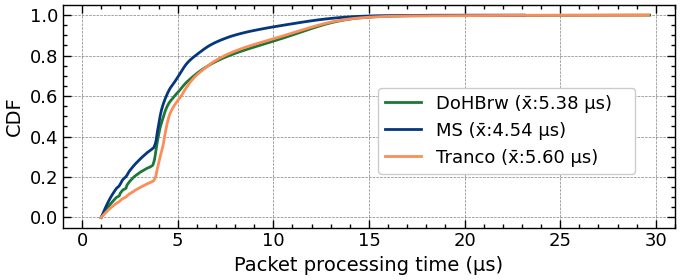

In [8]:
# proc_time_list = proc_time("/home/admin/C2_TLS/datasets","proc_logs")
plot_multiple_cdfs(proc_time_list,\
                labels=["DoHBrw","MS","Tranco"], linestyle='-')

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scienceplots
import datetime
import os
plt.style.use(["science", "notebook", "grid"])

def plot_multiple_cdfs_multiple_plots(lists, labels=None, **kwargs):
    """
    Plots the cumulative distribution function (CDF) of multiple lists.

    Parameters:
    - lists (list of lists): List of lists containing the data for which CDF needs to be plotted.
    - labels (list of str, optional): List of labels for the legend. If not provided, labels will be generated automatically.
    - kwargs: Additional keyword arguments to pass to plt.plot().

    Returns:
    - None
    """
    if labels is None:
        labels = [f'Data {i+1}' for i in range(len(lists))]

    # Define scientific colors in normalized RGB
    colors = [
        # (102/255, 194/255, 165/255),  # Light Green
        (27/255, 120/255, 55/255),    # Dark Green
        #(141/255, 160/255, 203/255),  # Light Blue
         (5/255, 55/255, 124/255),     # Dark Blue
        (252/255, 141/255, 89/255),   # Muted Orange (Adjusted Yellow)
        (165/255, 0/255, 38/255)      # Dark Red
    ]
    
    fig, axes = plt.subplots(1, 1, figsize=(7, 3))

    x_index = 0
    y_index = 0
    index = 0
    for list in lists:
        if(y_index != 0):
            if(y_index%2==0):
                x_index +=1
                y_index =0
        
        list_data = []
        for data in list:
            list_data.extend(data)
        # for i, (data, label) in enumerate(zip(list, labels)):
        #     list_data.extend(data)
            # list_data+=data

        sorted_data = np.sort(list_data)
        sorted_data = sorted_data[30:-10]
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        # , std: {str(np.std(sorted_data))[:3]} \u00B5s)
        label = labels[index]
        label += f" (x\u0304:{str(np.mean(sorted_data))[:4]} \u00B5s)" 
        axes.plot(sorted_data, cdf, label=label, color=colors[index % len(colors)], **kwargs)
        index+=1
        # axes[x_index][y_index].plot(sorted_data, cdf, label=label, color=colors[i % len(colors)], **kwargs)

        # if(x_index == 1):
        #     axes[x_index][y_index].set_xlabel('Packet processing time (\u00B5s)', fontsize=14)
        # if(y_index == 0):
        #     axes[x_index][y_index].set_ylabel('CDF', fontsize=14)
        # axes[x_index][y_index].set_xlim(-1,20)
        # axes[x_index][y_index].tick_params(axis='both', labelsize=13)

    axes.set_xlabel('Packet processing time (\u00B5s)', fontsize=14)
    axes.set_ylabel('CDF', fontsize=14)
    axes.set_xlim(-1,42)
    axes.tick_params(axis='both', labelsize=13)
        
    plt.grid(True)
    plt.tight_layout()
        # y_index+=1

    legend = axes.legend(bbox_to_anchor=(0.45, 0.2, 0.5, 0.1), loc="lower left", ncol=1, mode="expand", fontsize=13)
    # plt.savefig("Processing_latency_dif_throughput.pdf")
    plt.show()

def load_delays(file_or_dir):
    delays = []
    
    if os.path.isdir(file_or_dir):
        files = [os.path.join(file_or_dir, f) for f in os.listdir(file_or_dir) if os.path.isfile(os.path.join(file_or_dir, f))]
    else:
        files = [file_or_dir]

    for file in files:
        with open(file, 'r') as fr:
            for line in fr:
                line = line.strip()
                delay = float(line.split(',')[-1])
                if delay > 0:
                    delays.append(int(delay))
                    
    return delays

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def proc_time(log_directory,exp_type):

    ###################################################DOH
    log_directory_doh = log_directory+"/DoHBrw"
    log_files_doh = []
    for dirpath, dirnames, filenames in os.walk(log_directory_doh):
        for filename in filenames:
            if exp_type in dirpath and filename.endswith('.csv'):
                log_files_doh.append(os.path.join(dirpath, filename))
       
    df_list_doh = []

    for log_file in log_files_doh:
        df = pd.read_csv(log_file, sep=" ", header=None, skiprows=200, low_memory=False)
        df_list_doh.append(df)
    
    df_list_doh = pd.concat(df_list_doh, ignore_index=True)
    df_list_doh = df_list_doh[(df_list_doh[1] >= 1000)]
    DPDK_proc_time_doh = df_list_doh[1]

    ###################################################MS
    log_directory_ms = log_directory+"/ms"
    log_files_ms = []
    for dirpath, dirnames, filenames in os.walk(log_directory_ms):
        for filename in filenames:
            if exp_type in dirpath and filename.endswith('.csv'):
                log_files_ms.append(os.path.join(dirpath, filename))
       
    df_list_ms = []

    for log_file in log_files_ms:
        df = pd.read_csv(log_file, sep=" ", header=None, skiprows=200, low_memory=False)
        df_list_ms.append(df)
    
    df_list_ms = pd.concat(df_list_ms, ignore_index=True)
    df_list_ms = df_list_ms[(df_list_ms[1] >= 1000)]
    DPDK_proc_time_ms = df_list_ms[1]

    ###################################################MS
    log_directory_tranco = log_directory+"/tranco"
    log_files_tranco = []
    for dirpath, dirnames, filenames in os.walk(log_directory_tranco):
        for filename in filenames:
            if exp_type in dirpath and filename.endswith('.csv'):
                log_files_tranco.append(os.path.join(dirpath, filename))
       
    df_list_tranco = []

    for log_file in log_files_tranco:
        df = pd.read_csv(log_file, sep=" ", header=None, skiprows=200, low_memory=False)
        df_list_tranco.append(df)
    
    df_list_tranco = pd.concat(df_list_tranco, ignore_index=True)
    df_list_tranco = df_list_tranco[(df_list_tranco[1] >= 1000)]
    DPDK_proc_time_tranco = df_list_tranco[1]


    # Remove NaN values from the arrays
    DPDK_proc_time_doh = DPDK_proc_time_doh[~np.isnan(DPDK_proc_time_doh)]
    DPDK_proc_time_ms = DPDK_proc_time_ms[~np.isnan(DPDK_proc_time_ms)]
    DPDK_proc_time_tranco = DPDK_proc_time_tranco[~np.isnan(DPDK_proc_time_tranco)]

    # Convert from nanoseconds to microseconds (divide by 1000)
    DPDK_proc_time_doh /= 1000
    DPDK_proc_time_ms /= 1000
    DPDK_proc_time_tranco /= 1000

    # Calculate the 99th percentile for each series
    DPDK_percentile_99_doh = np.percentile(DPDK_proc_time_doh, 99.9)
    DPDK_percentile_99_ms = np.percentile(DPDK_proc_time_ms, 99.9)
    DPDK_percentile_99_tranco = np.percentile(DPDK_proc_time_tranco, 99.9)

    # Remove values above the 99th percentile (anomalies)
    DPDK_proc_time_doh = DPDK_proc_time_doh[DPDK_proc_time_doh < DPDK_percentile_99_doh]
    DPDK_proc_time_ms = DPDK_proc_time_ms[DPDK_proc_time_ms < DPDK_percentile_99_ms]
    DPDK_proc_time_tranco = DPDK_proc_time_tranco[DPDK_proc_time_tranco < DPDK_percentile_99_tranco]


    # Plotting the CDF for each series
    plt.figure(figsize=(10, 6))

    # Calculate the CDF for DPDK_proc_time
    DPDK_sorted_doh = np.sort(DPDK_proc_time_doh)
    DPDK_sorted_ms = np.sort(DPDK_proc_time_ms)
    DPDK_sorted_tranco = np.sort(DPDK_proc_time_tranco)

    # plot_multiple_cdfs([DPDK_sorted_doh,DPDK_sorted_ms,DPDK_sorted_tranco],\
    #                 labels=["doh","ms","tranco"], linestyle='-')

    return [DPDK_sorted_doh,DPDK_sorted_ms,DPDK_sorted_tranco]

In [ ]:
# list_proc_time_5Gbps = proc_time("/home/admin/C2_TLS/datasets","proc_logs_5Gbps")
# list_proc_time_10Gbps = proc_time("/home/admin/C2_TLS/datasets","proc_logs_10Gbps")
# list_proc_time_15Gbps = proc_time("/home/admin/C2_TLS/datasets","proc_logs_15Gbps")
# list_proc_time_20Gbps = proc_time("/home/admin/C2_TLS/datasets","proc_logs_20Gbps")
# list_proc_time_50Gbps = proc_time("/home/admin/C2_TLS/datasets","proc_logs_50Gbps")

# lists = [list_proc_time_5Gbps,list_proc_time_10Gbps,list_proc_time_15Gbps,list_proc_time_20Gbps,list_proc_time_50Gbps ]

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

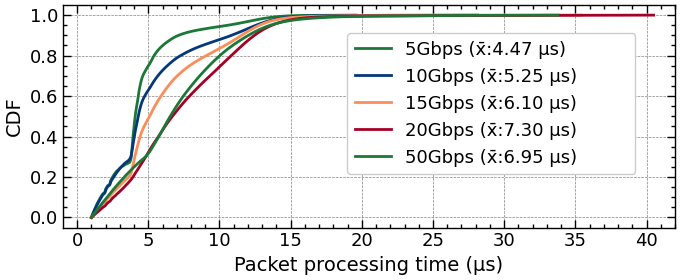

In [11]:
plot_multiple_cdfs_multiple_plots(lists,\
                labels=["5Gbps","10Gbps","15Gbps","20Gbps","50Gbps"], linestyle='-')